In [92]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import tqdm
import torch.nn as nn

In [96]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [97]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [98]:

classes = os.listdir('Data/images_original')
classes.sort()
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}

images = []
labels = []
for i, cls_name in enumerate(classes):
    path = os.path.join('Data/images_original', cls_name)
    for img_file in os.listdir(path):
        img_path = os.path.join(path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transform(img)
        images.append(img)
        labels.append(i)
images = torch.stack(images).to(device)
labels = torch.tensor(labels).to(device)
print(images.shape, labels.shape)

torch.Size([999, 3, 256, 256]) torch.Size([999])


In [99]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=42)
print(train_images.shape, test_images.shape, train_labels.shape, test_labels.shape)

torch.Size([799, 3, 256, 256]) torch.Size([200, 3, 256, 256]) torch.Size([799]) torch.Size([200])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'jazz')

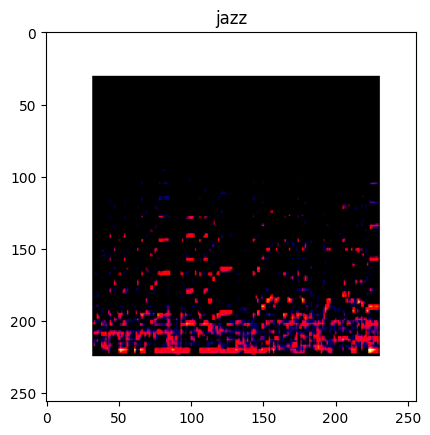

In [100]:
# print a image from the dataset
import matplotlib.pyplot as plt

plt.imshow(train_images[110].cpu().numpy().transpose(1, 2, 0))
plt.title(idx_to_class[train_labels[110].item()])

In [101]:

class MusicDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [102]:
dataset_train = MusicDataset(train_images, train_labels)
DataLoader_train = DataLoader(dataset_train, batch_size=50, shuffle=True)

In [103]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [104]:
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

Using cache found in /Users/liutianhao/.cache/torch/hub/facebookresearch_WSL-Images_main


In [105]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# 训练模型 
num_epochs = 30
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize best validation loss
patience_counter = 0  # Counter to keep track of the number of epochs without improvement
log = {}


for epoch in range(num_epochs):
    model.train()
    run_loss = 0.0
    for images, labels in tqdm.tqdm(DataLoader_train):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()

    model.eval()
    with torch.no_grad():
        test_outputs = model(test_images)
        test_loss = criterion(test_outputs, test_labels)
        pred = torch.argmax(test_outputs, dim=1)
        acc = (pred == test_labels).sum().item() / len(test_labels)

        # save the loss and accuracy
        log[epoch] = {'loss_train': loss.item(), 'loss_val': test_loss.item(), 'accuracy_val': acc}
        print(f'Epoch {epoch}, loss_train: {loss.item() / len(DataLoader_train)}, loss_val: {test_loss.item()}, accuracy_val: {acc}')

    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'find-tuned-vgg16.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:28<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# draw the loss and accuracy
import matplotlib.pyplot as plt
plt.figure()
plt.plot([log[k]['loss_train'] for k in log], label='train loss')
plt.plot([log[k]['loss_val'] for k in log], label='val loss')
plt.legend()
plt.show()  


# free GPU memory
